In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from ema_pytorch import EMA
from datetime import datetime
from utils.sim_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from utils.couzin_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from utils.dataset_utils import *
from geomloss import SamplesLoss
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
# Expert
max_steps = 300

# Training
num_generations = 3000
gamma = 0.999
deterministic=False # BC pretrain
performance_eval = 5
num_perturbations = 64

### Prey ###
lr_prey_policy = 2e-4
sigma_prey = 0.1

prey_dis_balance_factor = 2
prey_noise = 0.005
lr_prey_disc = 5e-4
lambda_gp_prey = 5
prey_update_mode = "avoid"


### Predator ###
lr_pred_policy = 1e-4
sigma_pred = 0.08

pred_dis_balance_factor = 2
pred_noise = 0.005
lr_pred_disc = 2e-4
lambda_gp_pred = 10
pred_update_mode = "attack"


# Env Settings
height = 50
width = 50
prey_speed = 5
pred_speed = 5
step_size = 0.25
theta_dot_max = 0.5
max_turn = float(theta_dot_max * step_size) + 1e-12

pert_steps = 100
init_steps = 500

env_settings = (height, width, prey_speed, pred_speed, step_size, max_turn, pert_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib tk
exp_pred_sequence, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(
                                        visualization="off", 
                                        max_steps=init_steps, 
                                        constant_speed=prey_speed, shark_speed=pred_speed, 
                                        area_width=width, area_height=height,
                                        dt = step_size,
                                        alpha=0.01,
                                        theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                        number_of_sharks=1, n=32)

exp_pred_sequence = exp_pred_sequence.to(device)
exp_prey_sequence = exp_prey_sequence.to(device)
init_pool = init_pool.to(device)

print("\nPred Shape:", exp_pred_sequence.shape)
print("Prey Shape:", exp_prey_sequence.shape)

exp_pred_tensor = sliding_window(exp_pred_sequence, window_size=10)
exp_prey_tensor = sliding_window(exp_prey_sequence, window_size=10)

print("\nPred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)



Pred Shape: torch.Size([500, 1, 32, 5])
Prey Shape: torch.Size([500, 32, 32, 6])

Pred Tensor Shape: torch.Size([491, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([491, 10, 32, 32, 6])


In [ ]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=100, optimizer=prey_optimizer, role="prey")

for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=80, optimizer=pred_optimizer, role="predator")

for p in pred_encoder.parameters():
    p.requires_grad = False

print("Predator Encoder trained & frozen.")

epoch 010: loss=23.092302 sim=0.0528 std=1.3341 cov=0.3522 std_mean=0.333
epoch 020: loss=22.048145 sim=0.0423 std=1.2704 cov=0.3866 std_mean=0.365
epoch 030: loss=21.632029 sim=0.0448 std=1.2285 cov=0.4170 std_mean=0.386
epoch 040: loss=21.322933 sim=0.0415 std=1.1897 cov=0.4880 std_mean=0.405
epoch 050: loss=20.797806 sim=0.0398 std=1.1683 cov=0.4554 std_mean=0.416
epoch 060: loss=20.501312 sim=0.0424 std=1.1175 cov=0.5360 std_mean=0.441
epoch 070: loss=20.419947 sim=0.0382 std=1.1222 cov=0.5264 std_mean=0.439
epoch 080: loss=20.561335 sim=0.0415 std=1.0829 cov=0.6563 std_mean=0.459
epoch 090: loss=20.423748 sim=0.0438 std=1.0985 cov=0.5705 std_mean=0.451
epoch 100: loss=20.353504 sim=0.0420 std=1.1039 cov=0.5493 std_mean=0.448
Prey Encoder trained & frozen.

epoch 010: loss=24.235512 sim=0.0535 std=1.4245 cov=0.3058 std_mean=0.288
epoch 020: loss=24.158596 sim=0.0450 std=1.4171 cov=0.3551 std_mean=0.291
epoch 030: loss=22.930761 sim=0.0427 std=1.3427 cov=0.3445 std_mean=0.329
epoch 

In [5]:
%matplotlib inline
prey_policy = ModularPolicy(features=5).to(device)
#pretrain_policy(prey_policy, "prey", expert_data=exp_prey_tensor, batch_size=4048, epochs=5, lr=1e-3, deterministic=deterministic, device=device)
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Prey Policy pretrained.\n")

pred_policy = ModularPolicy(features=4).to(device)
#pretrain_policy(pred_policy, "predator", expert_data=exp_pred_tensor, batch_size=4048, epochs=5, lr=1e-3, deterministic=deterministic, device=device)
ema_pred = EMA(pred_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Predator Policy pretrained.\n")

Prey Policy pretrained.

Predator Policy pretrained.



In [6]:
prey_mmd_loss = MMDLoss(encoder=prey_encoder, role="prey").to(device)
prey_discriminator = Discriminator(encoder=prey_encoder, role="prey", z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_prey_disc, alpha=0.99, eps=1e-08)


pred_mmd_loss = MMDLoss(encoder=pred_encoder, role="predator").to(device)
pred_discriminator = Discriminator(encoder=pred_encoder, role="predator", z_dim=32).to(device)
pred_discriminator.set_parameters(init=True)
optim_disc_pred = torch.optim.RMSprop(pred_discriminator.parameters(), lr=lr_pred_disc, alpha=0.99, eps=1e-08)

sinkhorn_loss = SamplesLoss(loss="sinkhorn", backend="tensorized")

In [ ]:
metrics_list = []
policy_metrics_list = []
disc_metrics_list = []

for gen in range(num_generations):
    rollout_prey_policy = ema_prey.ema_model.to("cuda")
    rollout_pred_policy = ema_pred.ema_model.to("cuda")
    
    gen_pred_tensor, gen_prey_tensor = run_env_vectorized(prey_policy=rollout_prey_policy, 
                                                          pred_policy=rollout_pred_policy, 
                                                          n_prey=32, n_pred=1, max_steps=100,
                                                          init_pool=init_pool)


    for i in range(pred_dis_balance_factor):
        # Predator Discriminator Update (larger batch size for imbalance)
        expert_pred_batch = sample_data(exp_pred_tensor, batch_size=20, window_len=10).to(device)
        generative_pred_batch = sample_data(gen_pred_tensor, batch_size=20, window_len=10).to(device)

        dis_metric_pred = pred_discriminator.update(expert_pred_batch, generative_pred_batch, optim_disc_pred, 
                                                    lambda_gp_pred, noise=pred_noise, generation=gen, num_generations=num_generations)


    for i in range(prey_dis_balance_factor):
        # Prey Discriminator Update
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp_prey, noise=prey_noise, generation=gen, num_generations=num_generations)

        disc_metrics_list.append((dis_metric_prey, dis_metric_pred))                                            
    
        
    # Predator Policy Update
    init_pos = init_positions(init_pool, batch=num_perturbations, mode="dual")

    pin_pred_metrics = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="pred", module="pairwise", mode=pred_update_mode, 
                                   discriminator=pred_discriminator, lr=lr_pred_policy, sigma=sigma_pred, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    an_pred_metrics  = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="pred", module="attention", mode=pred_update_mode, 
                                   discriminator=pred_discriminator, lr=lr_pred_policy, sigma=sigma_pred,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_pred.update()

    # Prey Policy Update
    pin_prey_metrics = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="prey", module="pairwise", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_prey_policy, sigma=sigma_prey, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    an_prey_metrics  = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="prey", module="attention", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_prey_policy, sigma=sigma_prey,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_prey.update()

    policy_metrics_list.append({"predator": (pin_pred_metrics, an_pred_metrics), "prey": (pin_prey_metrics, an_prey_metrics)})
    
    lr_pred_policy *= gamma
    lr_prey_policy *= gamma
    sigma_pred *= gamma
    sigma_prey *= gamma

    current_prey_state = ema_prey.ema_model.state_dict()
    current_pred_state = ema_pred.ema_model.state_dict()

    if gen % performance_eval == 0:
        metrics = calculate_metrics(pred_policy=pred_policy, prey_policy=prey_policy, 
                                    prey_encoder=prey_encoder, pred_encoder=pred_encoder,
                                    exp_prey_tensor=exp_prey_tensor, exp_pred_tensor=exp_pred_tensor,
                                    prey_mmd_loss=prey_mmd_loss, pred_mmd_loss=pred_mmd_loss, sinkhorn_loss=sinkhorn_loss,
                                    init_pool=init_pool, env_settings=env_settings, device="cuda")
        metrics_list.append(metrics)

        best_prey = metrics["mmd_prey_mean"]
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

        best_pred = metrics["mmd_pred_mean"]
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}
        
    if metrics["mmd_prey_mean"] < best_prey:
        best_prey = metrics["mmd_prey_mean"]
        print(f"New best Prey MMD: {best_prey.item()}\n")
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

    if metrics["mmd_pred_mean"] < best_pred:
        best_pred = metrics["mmd_pred_mean"]
        print(f"New best Predator MMD: {best_pred.item()}\n")
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}

    
    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print(f"[PREY] MMD: {metrics['mmd_prey_mean']:.4f} ± {metrics['mmd_prey_std']:.4f} | Sinkhorn: {metrics['sinkhorn_prey_mean']:.4f} ± {metrics['sinkhorn_prey_std']:.4f}")
    print("--------------------------------")
    print(f"[PRED] PIN Network:   {pin_pred_metrics}")
    print(f"[PRED] AN Network:    {an_pred_metrics}")
    print(f"[PRED] Discriminator: {dis_metric_pred}")
    print(f"[PRED] Score Diff: {abs(dis_metric_pred['expert_score_mean'] - dis_metric_pred['policy_score_mean'])}")
    print(f"[PRED] MMD: {metrics['mmd_pred_mean']:.4f} ± {metrics['mmd_pred_std']:.4f} | Sinkhorn: {metrics['sinkhorn_pred_mean']:.4f} ± {metrics['sinkhorn_pred_std']:.4f}\n")


prey_policy.load_state_dict(best_prey_policy_state, strict=True)
pred_policy.load_state_dict(best_pred_policy_state, strict=True)

Generation 1
[PREY] PIN Network:   {'diff_min': -0.286926, 'diff_max': 0.188418, 'diff_mean': -0.000313, 'diff_std': 0.089218, 'delta_norm': 0.09245, 'clip_ratio': 0.702445, 'delta_raw_norm': 0.131612, 'max_delta_norm': 0.09245}
[PREY] AN Network:    {'diff_min': -0.116577, 'diff_max': 0.05131, 'diff_mean': -0.005149, 'diff_std': 0.02756, 'delta_norm': 0.091442, 'clip_ratio': 0.70047, 'delta_raw_norm': 0.130543, 'max_delta_norm': 0.091442}
[PREY] Discriminator: {'dis_loss': -0.0002, 'dis_loss_gp': 4.939, 'grad_penalty': 0.9878, 'expert_score_mean': -0.0954, 'policy_score_mean': -0.0956}
[PREY] Score Diff: 0.00020000000000000573
[PREY] MMD: 0.3124 ± 0.0669 | Sinkhorn: 0.0001 ± 0.0000
--------------------------------
[PRED] PIN Network:   {'diff_min': -0.346305, 'diff_max': 0.413267, 'diff_mean': -0.0145, 'diff_std': 0.117792, 'delta_norm': 0.093022, 'clip_ratio': 0.91263, 'delta_raw_norm': 0.101928, 'max_delta_norm': 0.093022}
[PRED] AN Network:    {'diff_min': -0.240734, 'diff_max': 0.

In [ ]:
base_dir = Path(r"..\data\2. Training\training\SequencePredPrey - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

prey_path = run_dir / "prey_policy.pth"
torch.save(prey_policy.state_dict(), prey_path)

pred_path = run_dir / "pred_policy.pth"
torch.save(pred_policy.state_dict(), pred_path)

In [ ]:
mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds = get_expert_values(exp_pred_tensor=exp_pred_tensor, exp_prey_tensor=exp_prey_tensor, 
                                                                        prey_mmd_loss=prey_mmd_loss, pred_mmd_loss=pred_mmd_loss, 
                                                                        prey_encoder=prey_encoder, pred_encoder=pred_encoder, 
                                                                        sinkhorn_loss=sinkhorn_loss)

100%|██████████| 500/500 [00:14<00:00, 35.01it/s]


Expert Prey MMD: 0.02798383045196533 ± 0.018275310651463414
Expert Prey Sinkhorn: 0.00012475019327393966 ± 2.620060125721896e-05

Expert Pred MMD: 0.3040643663406372 ± 0.15326880469018916
Expert Pred Sinkhorn: 0.001996531319105998 ± 0.000350887634111318


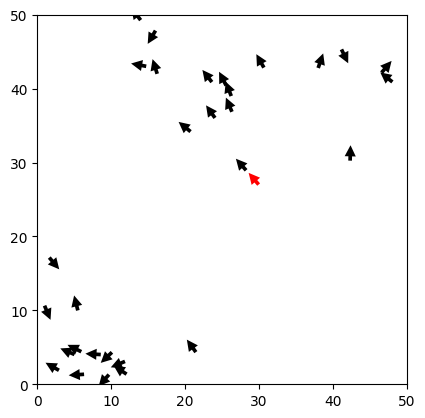

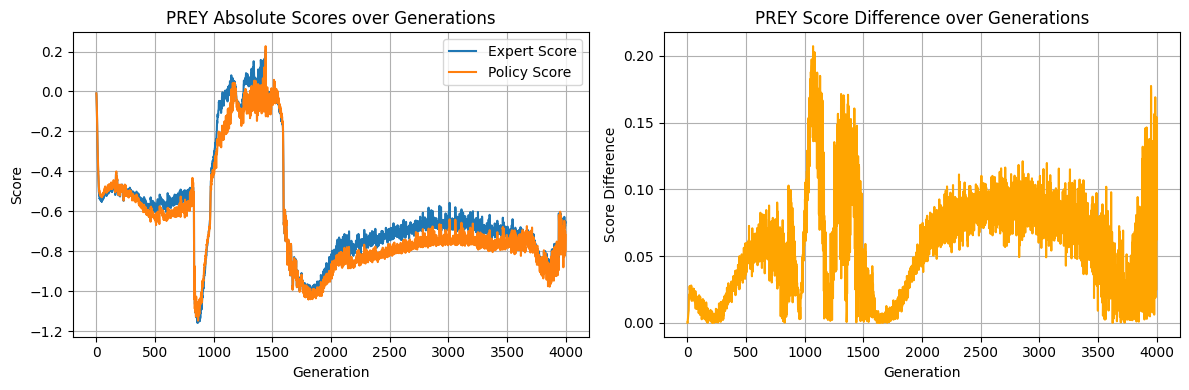

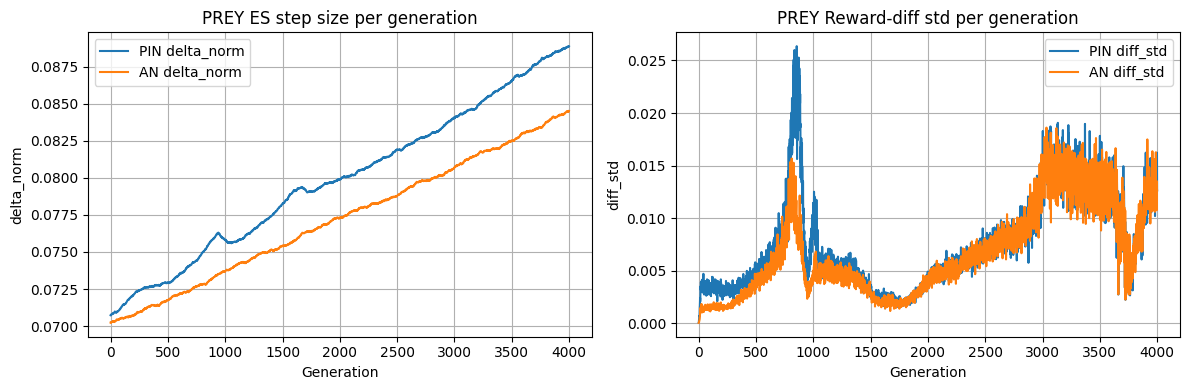

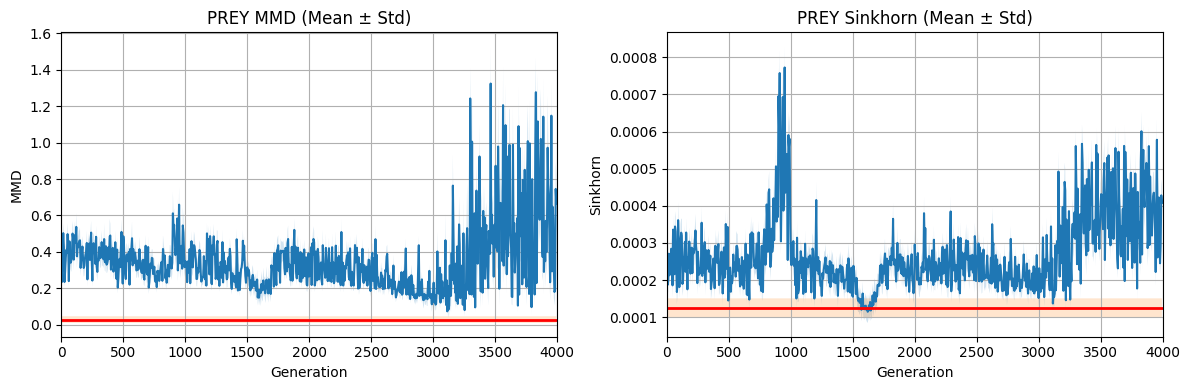

In [ ]:
%matplotlib inline
plot_train_metrics(disc_metrics_list, prey_dis_balance_factor, role="prey", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="prey", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="prey", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

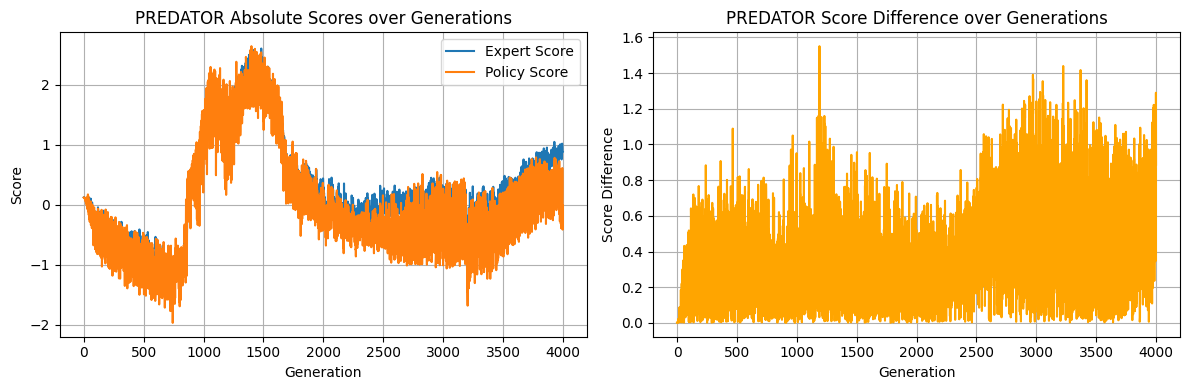

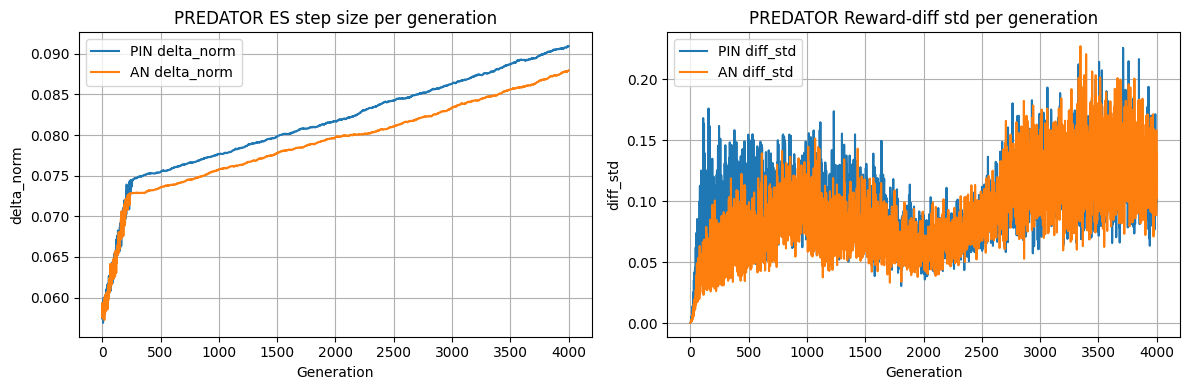

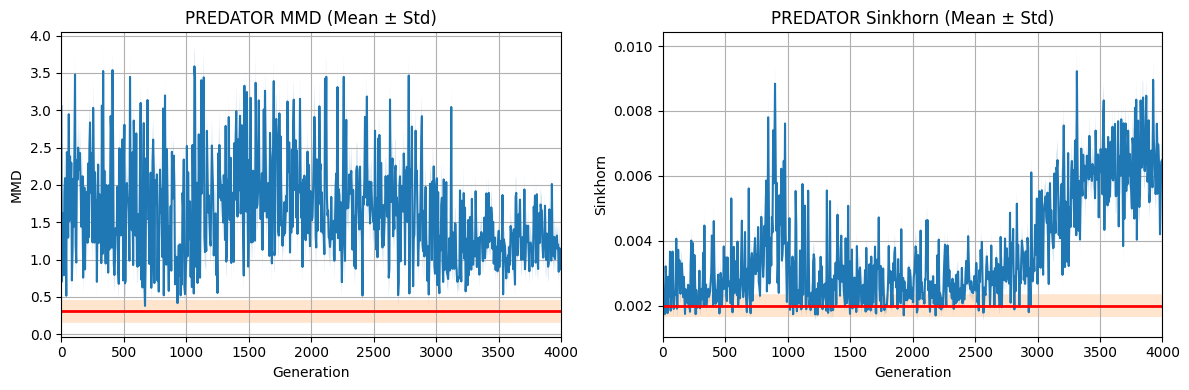

In [ ]:
%matplotlib inline
plot_train_metrics(disc_metrics_list, pred_dis_balance_factor, role="predator", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="predator", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="predator", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

In [ ]:
'''folder = "2026.01.12_00.13"
base_dir = Path(r"..\data\2. Training\training\PreyOnly - GAIL")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prey_path = base_dir / folder / "prey_policy.pth"
prey_policy = ModularPolicy(features=5).to(device)
prey_policy.load_state_dict(torch.load(prey_path, map_location=device))

pred_path = base_dir / folder / "pred_policy.pth"
pred_policy = ModularPolicy(features=4).to(device)
pred_policy.load_state_dict(torch.load(pred_path, map_location=device))'''

'folder = "2026.01.12_00.13"\nbase_dir = Path(r"..\\data\x02. Training\training\\PreyOnly - GAIL")\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nprey_path = base_dir / folder / "prey_policy.pth"\nprey_policy = ModularPolicy(features=5).to(device)\nprey_policy.load_state_dict(torch.load(prey_path, map_location=device))\n\npred_path = base_dir / folder / "pred_policy.pth"\npred_policy = ModularPolicy(features=4).to(device)\npred_policy.load_state_dict(torch.load(pred_path, map_location=device))'

In [ ]:
%matplotlib tk
gen_pred_tensor, gen_prey_tensor, gen_metrics = run_env_simulation(visualization='on', 
                                            prey_policy=prey_policy, pred_policy=pred_policy,
                                            n_prey=32, n_pred=1, 
                                            max_steps=100,
                                            pred_speed=pred_speed, prey_speed=prey_speed,
                                            area_width=width, area_height=height,
                                            max_turn = max_turn,
                                            step_size=step_size)

In [ ]:
%matplotlib tk
exp_pred_sequence, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(
                                        visualization="on", 
                                        max_steps=100, 
                                        constant_speed=prey_speed, shark_speed=pred_speed, 
                                        area_width=width, area_height=height,
                                        dt = step_size,
                                        alpha=0.01,
                                        theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                        number_of_sharks=1, n=32)

Min: -1.0
Max: 1.0
Mean: -0.002241741505400974


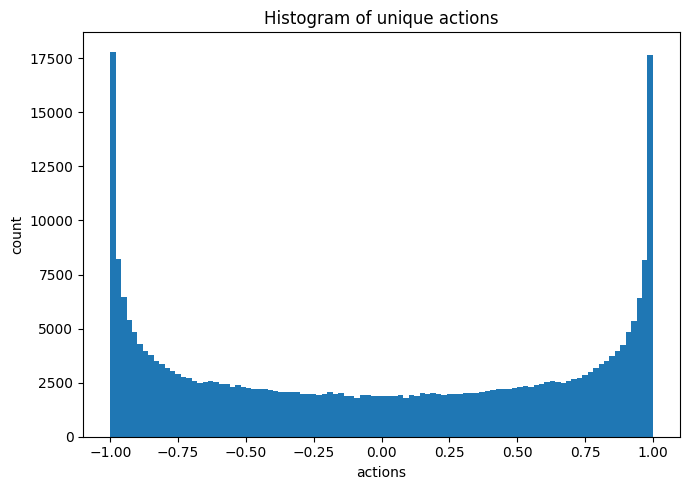

In [ ]:
%matplotlib inline
actions = gen_prey_tensor[..., 4]
actions_unique = list(set(actions.reshape(-1).tolist()))

print("Min:", min(actions_unique))
print("Max:", max(actions_unique))
print("Mean:", sum(actions_unique)/len(actions_unique))

plt.figure(figsize=(7,5))
plt.hist(actions_unique, bins=100)
plt.xlabel("actions")
plt.ylabel("count")
plt.title("Histogram of unique actions")
plt.tight_layout()
plt.show()